<a href="https://colab.research.google.com/github/aztecus1/Data-analysis-ERP-Nav/blob/main/Grid_search_for_best_LSTM_hyper_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import files
files.upload()

Saving ANNF.csv to ANNF (1).csv


{'ANNF.csv': b'format_date,Profit\r\n40909.00,2538.6\r\n40910.00,1653.53835\r\n40911.00,571.2\r\n40912.00,2976.36903\r\n40913.00,234.4\r\n40918.00,1114.6\r\n40920.00,739.2\r\n40921.00,2983.84602\r\n40922.00,3307.0767\r\n40923.00,2176.68\r\n40924.00,369.6\r\n40927.00,277.2\r\n40928.00,1502\r\n40930.00,1331\r\n40932.00,2583.01534\r\n40933.00,856.8\r\n40936.00,0\r\n40938.00,369.6\r\n40940.00,532.4\r\n40942.00,18945.8497\r\n40944.00,4718.2\r\n40945.00,277.2\r\n40946.00,1863.4\r\n40947.00,3581.2\r\n40948.00,856.8\r\n40949.00,2363.4\r\n40950.00,798.1\r\n40952.00,895.8\r\n40955.00,82.8\r\n40956.00,901.8\r\n40958.00,2976.36903\r\n40959.00,104.4\r\n40960.00,2341.1\r\n40964.00,55.2\r\n40966.00,2723.44602\r\n40967.00,1946.61534\r\n40972.00,1331\r\n40973.00,105.5\r\n40975.00,61.9\r\n40980.00,1385.2\r\n40981.00,527.5\r\n40982.00,166.2\r\n40985.00,1428\r\n40988.00,462\r\n40990.00,646.8\r\n40991.00,55.2\r\n40992.00,2645.66136\r\n40993.00,1661.70767\r\n40995.00,2976.36903\r\n40997.00,3373.6\r\n40999.0

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
df = pd.read_csv('ANNF.csv',usecols=[1])

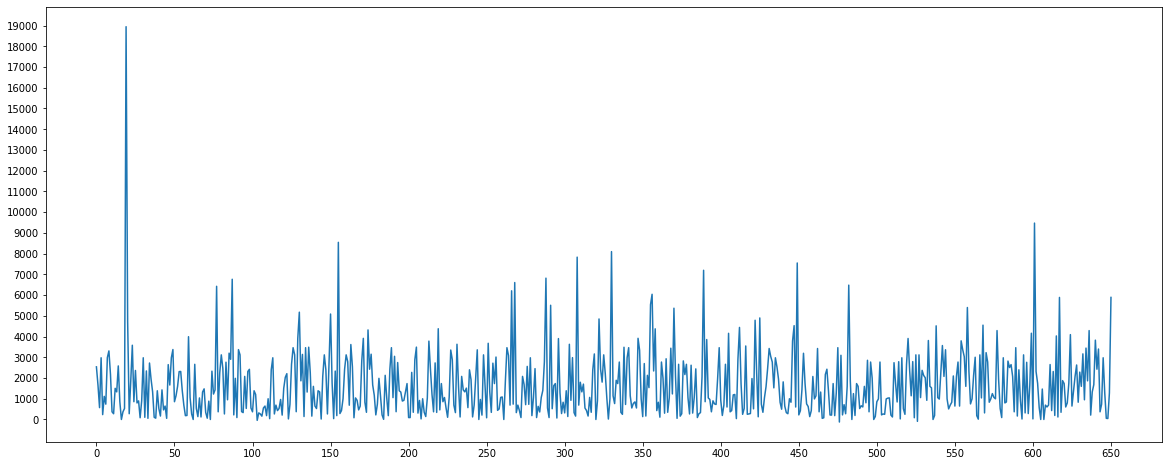

         Profit
0    2538.60000
1    1653.53835
2     571.20000
3    2976.36903
4     234.40000
..          ...
646  1293.60000
647    55.20000
648    46.80000
649  1285.20000
650  5887.10000

[651 rows x 1 columns]


In [ ]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(df)
plt.yticks(numpy.arange(0, 20000, 1000))
plt.xticks(numpy.arange(0, 700, 50))
plt.show()
print(df)

In [ ]:
dataset = df.values
dataset = dataset.astype('float32')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


520 131


In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# fit a model
def model_fit(train, config):
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

In [ ]:
# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = math.sqrt(mean_squared_error(test, predictions))
	print(' > %.3f' % error)
	return error

In [ ]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [ ]:
# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_nodes = [100]
	n_epochs = [100,500]
	n_batch = [1, 150]
	n_diff = [12]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

In [ ]:
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
	print(cfg, error)

In [ ]:
from numpy import array
from numpy import mean

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# transform list into supervised learning format
def series_to_supervised(data, n_in=3, n_out=1):
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return math.sqrt(mean_squared_error(actual, predicted))
 
# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]
 
# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
	n_features = 1
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model
 
# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error
 
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_nodes = [100]
	n_epochs = [x for x in range(100,201)]
	n_batch = [1,5,520]
	n_diff = [12]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs
 
# define dataset

data = df.values
# data split
n_test = 131
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
	print(cfg, error)

Total configs: 303
 > 2077.910
 > 1974.718
 > 2189.157
 > 2154.161
 > 1989.818
 > 2113.513
 > 2110.718
 > 2096.307
 > 2006.009


In [ ]:
# Model 1
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
516/516 - 20s - loss: 0.0111 - mae: 0.0568
Epoch 2/100
516/516 - 1s - loss: 8.3761e-05 - mae: 0.0077
Epoch 3/100
516/516 - 1s - loss: 5.9467e-05 - mae: 0.0064
Epoch 4/100
516/516 - 1s - loss: 3.7272e-05 - mae: 0.0050
Epoch 5/100
516/516 - 1s - loss: 1.8305e-05 - mae: 0.0034
Epoch 6/100
516/516 - 1s - loss: 9.6573e-06 - mae: 0.0025
Epoch 7/100
516/516 - 1s - loss: 6.5756e-06 - mae: 0.0020
Epoch 8/100
516/516 - 1s - loss: 6.5120e-06 - mae: 0.0020
Epoch 9/100
516/516 - 1s - loss: 8.6099e-06 - mae: 0.0023
Epoch 10/100
516/516 - 1s - loss: 8.4408e-06 - mae: 0.0023
Epoch 11/100
516/516 - 1s - loss: 1.0132e-05 - mae: 0.0025
Epoch 12/100
516/516 - 1s - loss: 9.7455e-06 - mae: 0.0024
Epoch 13/100
516/516 - 1s - loss: 2.0066e-05 - mae: 0.0034
Epoch 14/100
516/516 - 1s - loss: 1.3088e-05 - mae: 0.0027
Epoch 15/100
516/516 - 1s - loss: 1.1682e-05 - mae: 0.0026
Epoch 16/100
516/516 - 1s - loss: 1.6965e-05 - mae: 0.0030
Epoch 17/100
516/516 - 1s - loss: 1.6460e-05 - mae: 0.0030
Epoch 18/

In [ ]:
# Model 2
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
516/516 - 2s - loss: 0.0077 - mae: 0.0433
Epoch 2/100
516/516 - 1s - loss: 6.9442e-05 - mae: 0.0070
Epoch 3/100
516/516 - 1s - loss: 3.8279e-05 - mae: 0.0051
Epoch 4/100
516/516 - 1s - loss: 1.9407e-05 - mae: 0.0035
Epoch 5/100
516/516 - 1s - loss: 7.1201e-06 - mae: 0.0021
Epoch 6/100
516/516 - 1s - loss: 5.8095e-06 - mae: 0.0018
Epoch 7/100
516/516 - 1s - loss: 6.7208e-06 - mae: 0.0020
Epoch 8/100
516/516 - 1s - loss: 6.8327e-06 - mae: 0.0020
Epoch 9/100
516/516 - 1s - loss: 9.9474e-06 - mae: 0.0024
Epoch 10/100
516/516 - 1s - loss: 1.7898e-05 - mae: 0.0031
Epoch 11/100
516/516 - 1s - loss: 1.1792e-05 - mae: 0.0026
Epoch 12/100
516/516 - 1s - loss: 1.0888e-05 - mae: 0.0024
Epoch 13/100
516/516 - 1s - loss: 2.4622e-05 - mae: 0.0037
Epoch 14/100
516/516 - 1s - loss: 2.3065e-05 - mae: 0.0034
Epoch 15/100
516/516 - 1s - loss: 2.4694e-05 - mae: 0.0035
Epoch 16/100
516/516 - 1s - loss: 1.6103e-05 - mae: 0.0030
Epoch 17/100
516/516 - 1s - loss: 1.3072e-05 - mae: 0.0028
Epoch 18/1

In [ ]:
# Model 3
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
model.fit(trainX, trainY, epochs=100, batch_size=5, verbose=2)

Epoch 1/100
516/516 - 3s - loss: 0.0095 - mae: 0.0433
Epoch 2/100
516/516 - 1s - loss: 5.6332e-05 - mae: 0.0062
Epoch 3/100
516/516 - 1s - loss: 3.4131e-05 - mae: 0.0048
Epoch 4/100
516/516 - 1s - loss: 2.0206e-05 - mae: 0.0037
Epoch 5/100
516/516 - 1s - loss: 1.0805e-05 - mae: 0.0026
Epoch 6/100
516/516 - 1s - loss: 6.8098e-06 - mae: 0.0020
Epoch 7/100
516/516 - 1s - loss: 7.7735e-06 - mae: 0.0021
Epoch 8/100
516/516 - 1s - loss: 9.8382e-06 - mae: 0.0024
Epoch 9/100
516/516 - 1s - loss: 1.1485e-05 - mae: 0.0025
Epoch 10/100
516/516 - 1s - loss: 1.8181e-05 - mae: 0.0032
Epoch 11/100
516/516 - 1s - loss: 4.8481e-05 - mae: 0.0046
Epoch 12/100
516/516 - 1s - loss: 1.1913e-05 - mae: 0.0026
Epoch 13/100
516/516 - 1s - loss: 4.2330e-05 - mae: 0.0046
Epoch 14/100
516/516 - 1s - loss: 1.9377e-05 - mae: 0.0032
Epoch 15/100
516/516 - 1s - loss: 1.6697e-05 - mae: 0.0030
Epoch 16/100
516/516 - 1s - loss: 2.4282e-05 - mae: 0.0036
Epoch 17/100
516/516 - 1s - loss: 1.3992e-05 - mae: 0.0028
Epoch 18/1

In [ ]:
model.evaluate(trainX,trainY)

14/14 [==============================] - 0s 2ms/step - loss: 4.9057e-06 - mae: 0.0017


[4.905657533527119e-06, 0.0017133975634351373]

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
from sklearn.metrics import mean_absolute_error
r2 = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Test Score: %.2f MAE' % (r2))

Train Score: 2969.83 RMSE
Test Score: 12010.42 RMSE
Test Score: 2235.86 MAE


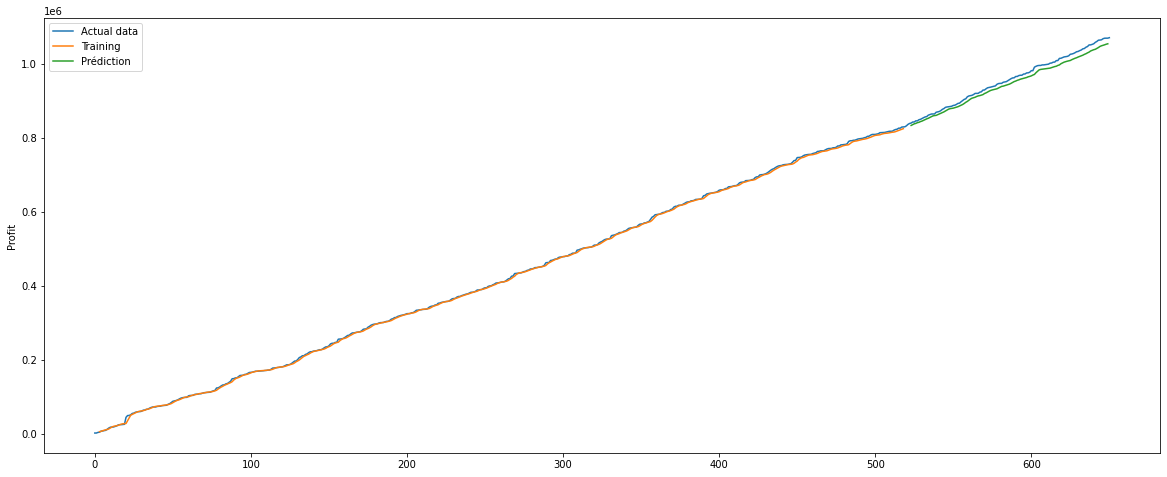

In [ ]:

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.ylabel("Profit")
plt.legend(['Actual data','Training','Prédiction'])
plt.show()
